# Parse elapsed times from GitHub Actions logs

In [1]:
from utz import *
import plotly.express as px

In [2]:
runs = {
    '4969272579': 'mamba',  # initial workflow, mamba CLI and conda-libmamba-solver only (5 jobs x 4 attempts)
    '4969923328': 'conda',  # conda only (5 jobs x 4 attempts)
    '4970360885': 'both',   # additional runs of all 3 builds (conda, conda-libmamba-solver, mamba; 5 jobs x 4 attempts each)
    '4972844135': 'both (ubuntu)',  # another round of both, switched to ubuntu:20.04 instead of nvidia/cuda:11.6.1-base-ubuntu20.04 (doesn't seem to make a difference)
    '4972941899': 'conda (install solver without conda-forge)',  # avoid nondeterministic `conda-libmamba-solver` installation failures (caused by including `-c conda-forge`) that were present in the above runs
    '4973140153': 'both (ubuntu, simplified setup)',  # simplify the initial install/setup, don't bother pre-installing/pinning python or conda
}

### Local cache for logs and run info downloaded via the `gh` CLI

In [3]:
CACHE = '.cache'
if not exists(CACHE):
    os.makedirs(CACHE)

### Parse `elapsed` time (output by `time docker build …`) for all steps in a given job

In [4]:
# Plain `conda` builds had an initial setup install prior to this GHA run (which output an "elapsed" time that gets picked up by `get_elapsed_times` below)
min_conda_no_setup_run = '4973140153'

def rm_ansi(line):
    ansi_escape =re.compile(r'(\x9B|\x1B\[)[0-?]*[ -\/]*[@-~]')
    return ansi_escape.sub('', line)

def get_elapsed_times(run_id, job_id, build):
    path = f'{CACHE}/job-{job_id}.txt'
    if not exists(path):
        cmd = [ 'gh', 'run', 'view', '--job', f'{job_id}', '--log' ]
        with open(path, 'w') as f:
            subprocess.run(cmd, stdout=f)

    setup = None
    updates = []
    with open(path, 'r') as f:
        for line in f.readlines():
            m = search(r'(?P<elapsed>\S+)elapsed', rm_ansi(line))
            if m:
                elapsed = m['elapsed']
                if setup or (run_id > min_conda_no_setup_run and build == 'conda'):
                    updates.append(elapsed)
                else:
                    setup = elapsed
    rv = dict(updates=updates)
    if setup:
        rv['setup'] = setup
    return rv

### Parse elapsed times for all jobs in a given workflow run

In [5]:
def get_jobs_json(run_id, recompute=False):
    jobs_path = f'{CACHE}/run-{run_id}-jobs.json'
    if recompute or not exists(jobs_path):
        with open(jobs_path, 'w') as f:
            cmd = [ 'gh', 'run', 'view', run_id, '--json', 'jobs' ]
            err(f'Piping `{shlex.join(cmd)}` to {jobs_path}')
            subprocess.run(cmd, stdout=f)
    with open(jobs_path, 'r') as f:
        jobs_json = json.load(f)

    return jobs_json

def get_run_times(run_id, run_name, recompute=False):
    run_times_path = f'{CACHE}/run-{run_id}-times.parquet'
    if (
        recompute is True or
        recompute == 'times' or
        (isinstance(recompute, list) and run_id in recompute) or
        not exists(run_times_path)
    ):
        recompute_jobs = (
            recompute == 'jobs' or
            recompute is True or
            (isinstance(recompute, list) and 'jobs' in recompute)
        )
        jobs_json = get_jobs_json(run_id, recompute=recompute_jobs)
        jobs = (
            DF(jobs_json)
            .jobs
            .apply(Series)
            .rename(columns={ 'databaseId': 'job_id' })
            .set_index('job_id')
        )
        jobs = sxs(
            jobs,
            jobs.name.str.extract(r'(?P<build>mamba-(?:cli|solver)|conda-libmamba-solver|conda|mamba).*(?P<job>\d+)'),
            jobs.url.str.extract(r'^.*/(?P<url_id>\d+)$').url_id,
        )
        jobs['run_id'] = run_id
        jobs['run_name'] = run_name

        job_times = sxs(
            DF([
                dict(
                    job_id=job_id,
                    **get_elapsed_times(
                        run_id=run_id,
                        job_id=job_id,
                        build=jobs.loc[job_id, 'build'],
                    )
                )
                for job_id in jobs.index
            ])
            .set_index('job_id'),
            jobs[['url_id', 'run_id', 'conclusion', 'build', 'job']],
        )

        setups = job_times.setup.rename('elapsed_str').to_frame()
        setups['attempt'] = -1  # initial setup: install `conda-libmamba-solver`, `mamba`, or nothing (in the case of plain `conda` build)

        step_times = job_times.updates.apply(Series)
        step_times = (
            step_times
            .reset_index()
            .melt(
                'job_id',
                step_times.columns.tolist(),
                var_name='attempt',
                value_name='elapsed_str',
            )
            .dropna()
        )
        step_times = (
            pd.concat([ step_times, setups.reset_index() ])
            .set_index('job_id')
        )

        merged = step_times.merge(jobs[['build', 'run_id', 'run_name', 'conclusion']], on='job_id')
        p = merged.elapsed_str.str.extract(r'^(?P<m>\d+):(?P<s>\d+)\.(?P<cs>\d+)$').applymap(int)
        elapsed_s = p.m * 60 + p.s + p.cs / 100
        merged['elapsed_s'] = elapsed_s
        merged['elapsed_m'] = elapsed_s / 60
        merged = merged.drop(columns='elapsed_str')

        merged.loc[merged.build == 'mamba-solver', 'build'] = 'conda-libmamba-solver'
        merged.loc[merged.build == 'mamba-cli', 'build'] = 'mamba'
        fail_mask = merged.conclusion == 'failure'
        if fail_mask.sum():
            assert (merged[fail_mask].build == 'conda-libmamba-solver').all()
        merged['label'] = merged['build']
        merged.loc[fail_mask, 'label'] = 'conda-libmamba-solver (failed)'

        merged = (
            merged
            .reset_index()
            .set_index(['run_id', 'job_id', 'attempt'])
            .sort_index()
        )
        merged.to_parquet(run_times_path)
    return read_parquet(run_times_path)

### Combine elapsed times for all workflow runs listed in `runs` above

In [6]:
%%time
all_attempts = (
    pd.concat([
        get_run_times(run_id, run_name)
        for run_id, run_name in runs.items()
    ])
    .reset_index()
    .sort_values(['build', 'run_id', 'attempt'])
)
all_attempts

CPU times: user 37.2 ms, sys: 10 ms, total: 47.3 ms
Wall time: 62.9 ms


,run_id,job_id,attempt,build,run_name,conclusion,elapsed_s,elapsed_m,label
44,4969923328,13460568257,-1,conda,conda,success,208.72,3.478667,conda
49,4969923328,13460568304,-1,conda,conda,success,266.03,4.433833,conda
54,4969923328,13460568371,-1,conda,conda,success,185.75,3.095833,conda
59,4969923328,13460568428,-1,conda,conda,success,229.64,3.827333,conda
64,4969923328,13460568477,-1,conda,conda,success,186.54,3.109000,conda
...,...,...,...,...,...,...,...,...,...
236,4973140153,13466732541,0,mamba,"both (ubuntu, simplified setup)",success,129.24,2.154000,mamba
238,4973140153,13466732598,0,mamba,"both (ubuntu, simplified setup)",success,147.44,2.457333,mamba
240,4973140153,13466732648,0,mamba,"both (ubuntu, simplified setup)",success,128.56,2.142667,mamba
242,4973140153,13466732685,0,mamba,"both (ubuntu, simplified setup)",success,124.63,2.077167,mamba


Verify `job_id`:`build` is 1:1

In [7]:
assert (
    all_attempts
    [['job_id', 'build']]
    .value_counts()
    .reset_index()
    .job_id
    .value_counts()
    .value_counts()
    .index
    .tolist()
) == [1]

In [8]:
setups_mask = all_attempts.attempt == -1
setups = all_attempts[setups_mask]
setups

,run_id,job_id,attempt,build,run_name,conclusion,elapsed_s,elapsed_m,label
44,4969923328,13460568257,-1,conda,conda,success,208.72,3.478667,conda
49,4969923328,13460568304,-1,conda,conda,success,266.03,4.433833,conda
54,4969923328,13460568371,-1,conda,conda,success,185.75,3.095833,conda
59,4969923328,13460568428,-1,conda,conda,success,229.64,3.827333,conda
64,4969923328,13460568477,-1,conda,conda,success,186.54,3.109000,conda
116,4970360885,13461384677,-1,conda,both,success,166.01,2.766833,conda
121,4970360885,13461384738,-1,conda,both,success,197.29,3.288167,conda
126,4970360885,13461384773,-1,conda,both,success,173.13,2.885500,conda
131,4970360885,13461384800,-1,conda,both,success,208.55,3.475833,conda
136,4970360885,13461384829,-1,conda,both,success,167.26,2.787667,conda


In [9]:
updates = all_attempts[~setups_mask]
successes = updates[updates.conclusion == 'success']
successes

,run_id,job_id,attempt,build,run_name,conclusion,elapsed_s,elapsed_m,label
45,4969923328,13460568257,0,conda,conda,success,678.20,11.303333,conda
50,4969923328,13460568304,0,conda,conda,success,890.64,14.844000,conda
55,4969923328,13460568371,0,conda,conda,success,622.85,10.380833,conda
60,4969923328,13460568428,0,conda,conda,success,761.96,12.699333,conda
65,4969923328,13460568477,0,conda,conda,success,608.12,10.135333,conda
...,...,...,...,...,...,...,...,...,...
236,4973140153,13466732541,0,mamba,"both (ubuntu, simplified setup)",success,129.24,2.154000,mamba
238,4973140153,13466732598,0,mamba,"both (ubuntu, simplified setup)",success,147.44,2.457333,mamba
240,4973140153,13466732648,0,mamba,"both (ubuntu, simplified setup)",success,128.56,2.142667,mamba
242,4973140153,13466732685,0,mamba,"both (ubuntu, simplified setup)",success,124.63,2.077167,mamba


### Plot elapsed time for each build type

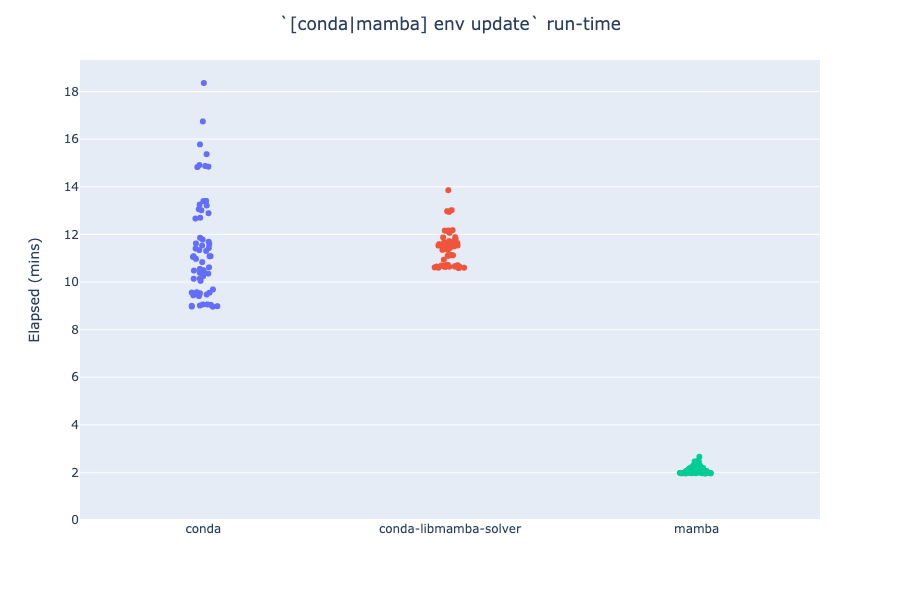

In [10]:
fig = px.strip(
    successes,
    x='build',
    y='elapsed_m',
    color='build',
    labels={ 'build': '', 'elapsed_m': 'Elapsed (mins)', 'run_name': 'environment.yml deps' },
).update_layout(
    title=dict(
        text='`[conda|mamba] env update` run-time',
        x=0.5,
    ),
    yaxis=dict(
        tickformat='%M',
    ),
    showlegend=False,
).update_yaxes(
    rangemode='tozero',
)
png_path = 'run-times.png'
fig.write_image(png_path, width=900, height=600)

from IPython.display import Image, display
display(Image(filename=png_path))
#fig.show()